Importing the needed libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from scipy.fft import fft, fftfreq
from scipy.signal import detrend

Defining a function to load the data from "Noale_Italy_26_7_dBm.csv"
This data is for the time period of 19.09.2022

In [2]:
def load_data():
    data = pd.read_csv('../data/Noale_Italy_26_7_dBm.csv')
    data['Date'] = pd.to_datetime(data['Date'])
    data['Value'] = pd.to_numeric(data['Value'])

    return data

Defining a function to plot the data from "Noale_Italy_26_7_dBm.csv"

In [3]:
def plot_data(data):
    plt.plot(data['Date'], data['Value'])
    plt.title('Data from Noale Italy 26 7')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Datetime [MM-DD HH]')
    plt.ylabel('dBm')
    plt.tight_layout()
    plt.savefig(f'../artifacts/date_to_value_plot_FOURIER.png', format='png')
    plt.show()

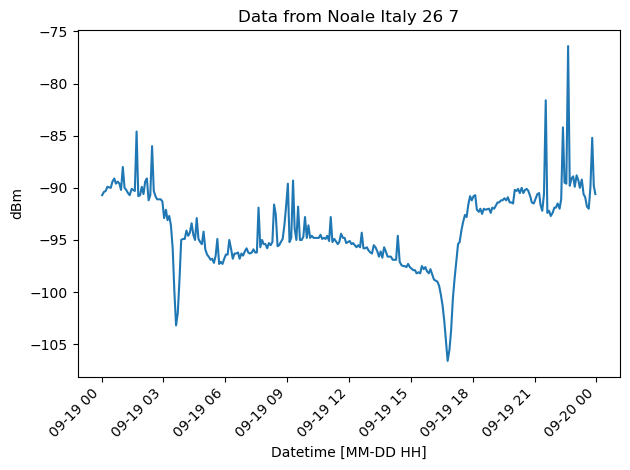

In [4]:
signal = load_data()
plot_data(signal)

b)

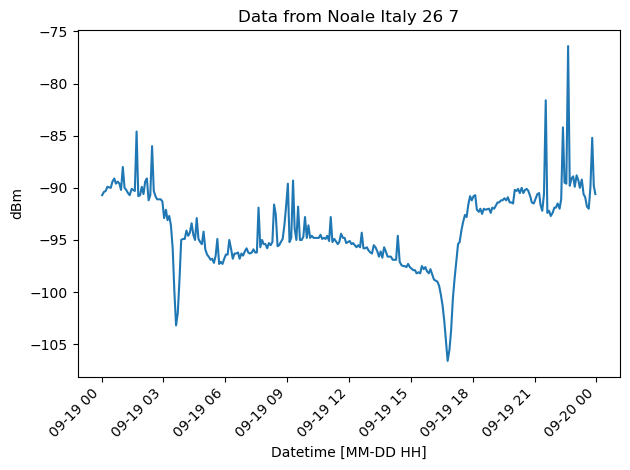

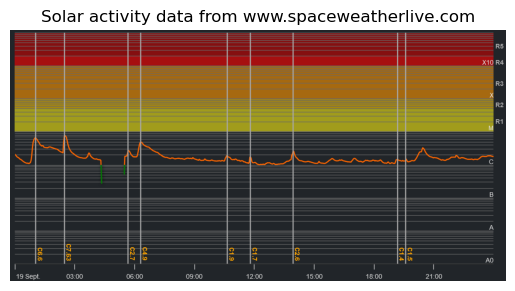

In [5]:
plot_data(signal)
plt.imshow(mpimg.imread('../data/solar-activity.png'))
plt.axis('off')  # Turn off axis labels
plt.title("Solar activity data from www.spaceweatherlive.com")
plt.show()

c) and d)

In [6]:
def plot_histogram(data):
    timediff = data['Date'].diff()[1:]
    timediff_minutes = timediff.dt.total_seconds() / 60

    bin_count = 8
    # Plot histogram

    plt.xlabel('Time Difference (Minutes)')
    plt.xlim(min(timediff_minutes), max(timediff_minutes))
    # Setting better alignment for x ticks
    plt.xticks(np.arange(min(timediff_minutes), max(timediff_minutes),
                         (max(timediff_minutes) - min(timediff_minutes)) / bin_count))
    hist_info = plt.hist(timediff_minutes, bins=bin_count, edgecolor='black')  # You can adjust the number of bins
    plt.ylabel('Frequency')
    plt.title('Histogram of Time Differences in Days')
    plt.savefig(f'../artifacts/timediff_histo_FOURIER.png', format='png')
    plt.show()

    return hist_info

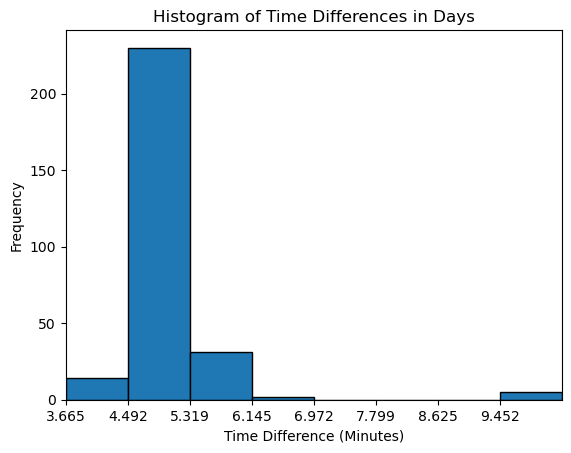

In [7]:
hist_info = plot_histogram(signal)

In [8]:
frequencies = hist_info[0]
bins = hist_info[1]
total_samples = sum(frequencies)
avg_sample_time = sum([frequencies[i] * ((bins[i] + bins[i+1]) * 0.5) for i in range(len(frequencies))]) / total_samples
missing_samples = 24*60 / 5 - total_samples - 1

{"minutes in a day": 24*60, "total": total_samples, "missing": missing_samples, "average sample time [min]": avg_sample_time}

{'minutes in a day': 1440,
 'total': 282.0,
 'missing': 5.0,
 'average sample time [min]': 5.05465913984929}

c)
    The average sample time is 5 minutes as shown above.
    The total samples in the file is 282.
    In my opinion 5 are missing because there is 1440 minutes in a day and 1440/5 - 282 - 1 = 5. The reason for the missing samples is likely a malfunction in the measuring system. I am deducting 1 because the last sample for the day is at 24:00 which is technically the next day at 00:00.
d)
    The histogram confirms my theory furthermore as most of the samples are taken around 5 minutes apart. Furthermore, there are 5 samples that are roughly 10 minutes apart and virtually no samples inbetween. This shows that the system did not take a sample 5 times, which is the conclusion I came to without the histogram.


e)

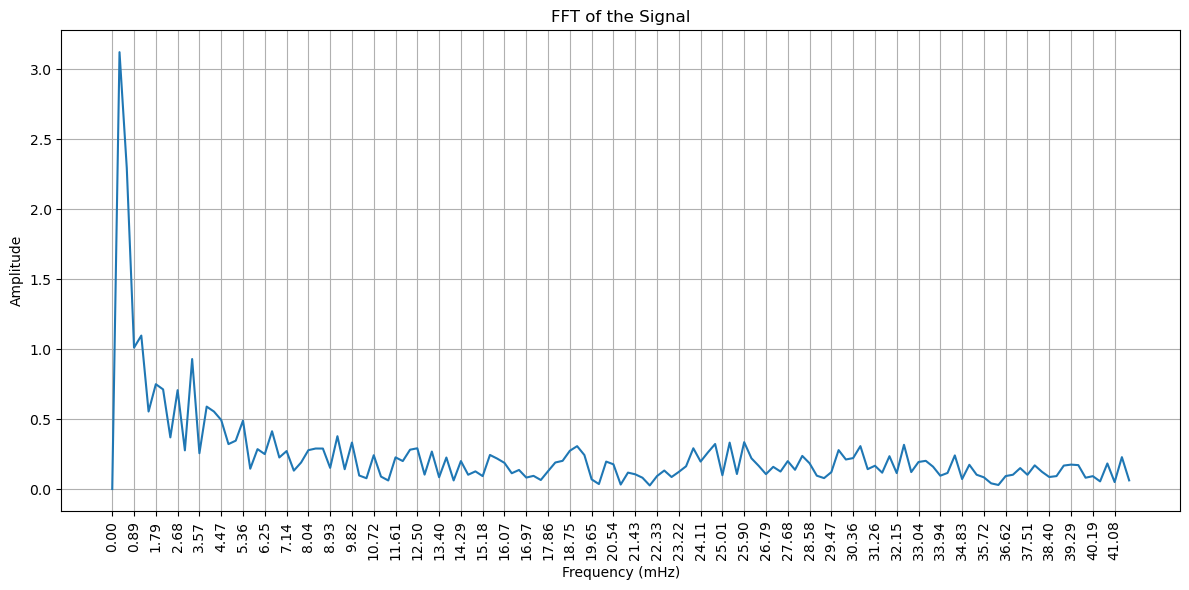

Dominant Frequencies: [0.03750807 0.03780575 0.03810344 0.03840112 0.0386988  0.03899649
 0.03929417 0.03959185 0.03988954 0.04018722 0.0404849  0.04078259
 0.04108027 0.04137795 0.04167563]


In [9]:
def plot_fft(data):
    data = np.asarray(data)
    data = detrend(data)
    N = len(data)
    # Perform FFT
    yf = fft(data)
    
    # Generate frequency bins (with appropriate sampling rate if applicable)
    sampling_rate = avg_sample_time/60   # 5 minutes per sample
    xf = fftfreq(int(N), 1 / sampling_rate)  # Frequency bins
    
    # Keep only the positive half of the spectrum
    xf = xf[:int(N // 2)]
    yf = yf[:int(N // 2)]
    
    # Plot FFT
    plt.figure(figsize=(12, 6))
    plt.plot(xf * 1000, 2.0 / N * np.abs(yf))  # Convert xf to mHz
    plt.title("FFT of the Signal")
    plt.xlabel("Frequency (mHz)")
    plt.ylabel("Amplitude")
    #plt.yscale('log')
    plt.xticks([xf[i] * 1000 for i in range(len(xf)) if i % 3 == 0], rotation=90)  # Adjust tick step
    plt.grid()
    plt.tight_layout()
    plt.savefig(f'../artifacts/fft_plot.png', format='png')
    plt.show()
    dominant_freqs = xf[np.argsort(np.abs(xf)**2)[-15:]]  # Top 5 frequencies
    print("Dominant Frequencies:", dominant_freqs)
plot_fft(signal['Value'])

Energy in time domain: 3655.0009
Energy in frequency domain: 3655.0009


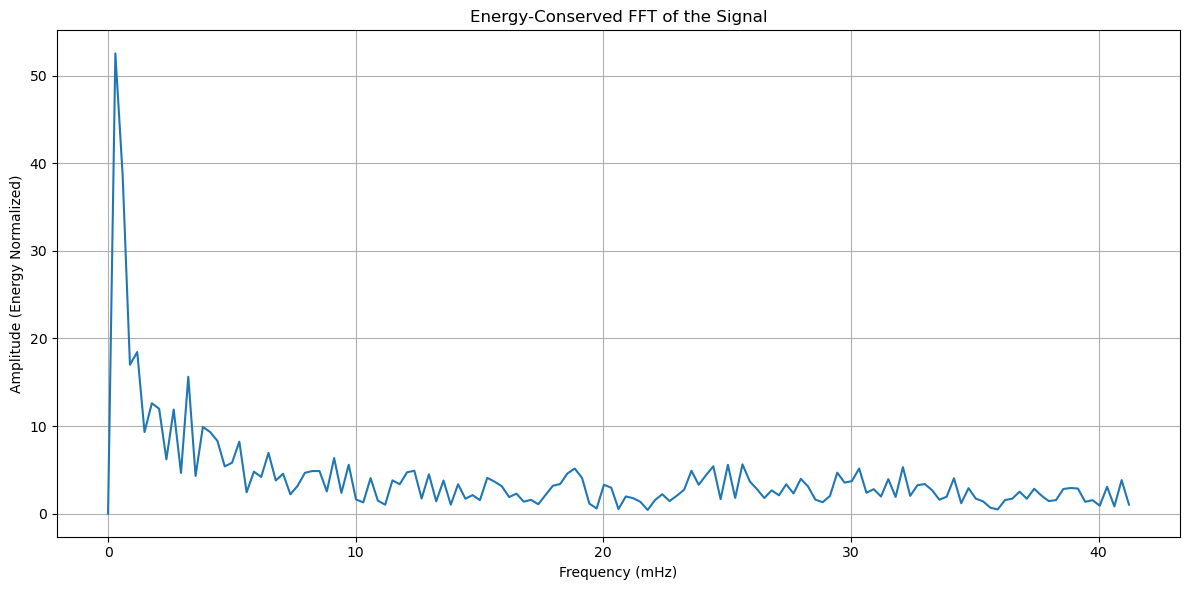

In [10]:
def plot_fft_energy_normalized(data):
    data = np.asarray(data)
    data = detrend(data)  # Remove any linear trends
    N = len(data)         # Total number of samples
    
    # Compute the FFT
    yf = fft(data)
    
    # Energy in time domain
    energy_time_domain = np.sum(data**2)
    
    # Normalize FFT amplitudes for energy conservation
    yf_normalized = yf / np.sqrt(N)
    
    # Energy in frequency domain (check Parseval's theorem)
    energy_freq_domain = np.sum(np.abs(yf_normalized)**2)
    print(f"Energy in time domain: {energy_time_domain:.4f}")
    print(f"Energy in frequency domain: {energy_freq_domain:.4f}")
    
    # Generate frequency bins
    sampling_rate = 5 / 60  # 5 minutes per sample
    xf = fftfreq(N, 1 / sampling_rate)
    
    # Keep only the positive half of the spectrum
    xf = xf[:N // 2]
    yf_normalized = yf_normalized[:N // 2]
    
    # Double amplitudes for one-sided spectrum
    yf_normalized[1:] = 2 * yf_normalized[1:]
    
    # Plot FFT
    plt.figure(figsize=(12, 6))
    plt.plot(xf * 1000, np.abs(yf_normalized))  # Convert xf to mHz
    plt.title("Energy-Conserved FFT of the Signal")
    plt.xlabel("Frequency (mHz)")
    plt.ylabel("Amplitude (Energy Normalized)")
    plt.grid()
    plt.tight_layout()
    plt.show()
    
    return xf, yf_normalized

# Call the function
xf, yf_normalized = plot_fft_energy_normalized(signal['Value'])


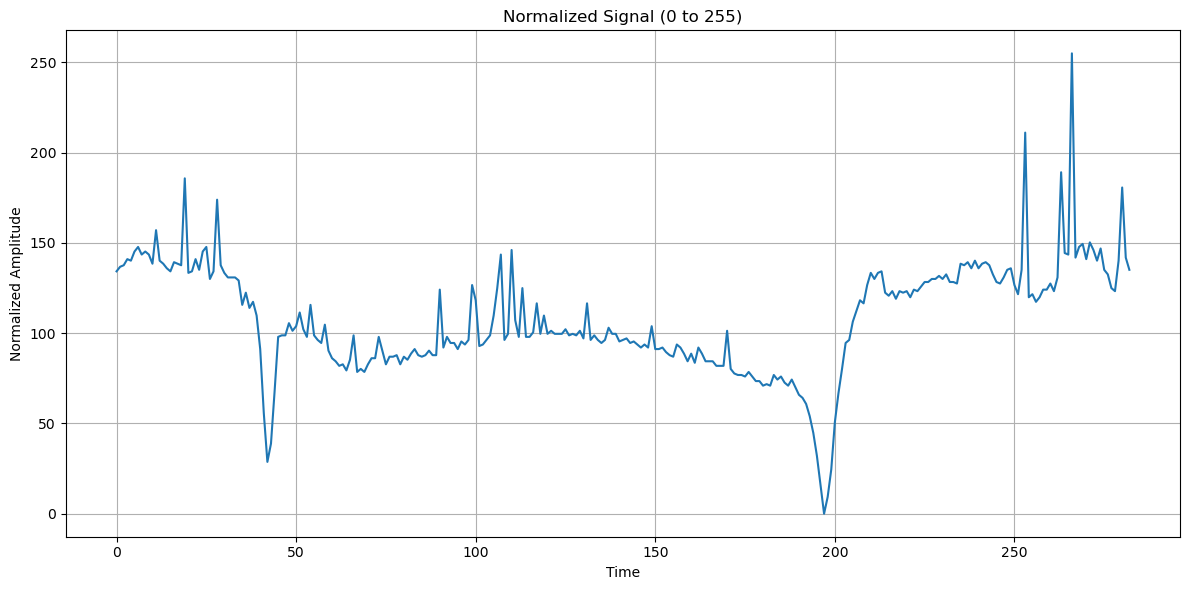

In [11]:
def normalize(data):
    x_max = np.max(data)
    x_min = np.min(data)
    normalized = ((data - x_min) / (x_max - x_min)) * 255
    return normalized

normalized_signal = normalize(signal['Value'])

# Plot the normalized signal
plt.figure(figsize=(12, 6))
plt.plot(normalized_signal)
plt.title("Normalized Signal (0 to 255)")
plt.xlabel("Time")
plt.ylabel("Normalized Amplitude")
plt.grid()
plt.tight_layout()
plt.savefig("../artifacts/normalized_signal.png")
plt.show()